In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../Projet_1_data/train.csv' # TODO: download train data and supply path here 
Y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# TRAINING MODELS

In [23]:
from Implementations import*

# Least squares

Preprocessing and parameters definition for optimization

In [15]:
y, tx, ids, tX_mean, tX_std = preprocess_data(Y, tX, ids, mean=None, std=None, param={'Build_poly': False})

seed = 1
k_fold = 4 
model = 'least_squares'
degrees = np.arange(1,16,1)

Parameters optimization

In [17]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y, tx, k_fold, model, degrees, params = None, seed = seed, feedback = True)

Optimizing degree 1/15, model: least_squares, arguments: None
Optimizing degree 2/15, model: least_squares, arguments: None
Optimizing degree 3/15, model: least_squares, arguments: None
Optimizing degree 4/15, model: least_squares, arguments: None
Optimizing degree 5/15, model: least_squares, arguments: None
Optimizing degree 6/15, model: least_squares, arguments: None
Optimizing degree 7/15, model: least_squares, arguments: None
Optimizing degree 8/15, model: least_squares, arguments: None
Optimizing degree 9/15, model: least_squares, arguments: None
Optimizing degree 10/15, model: least_squares, arguments: None
Optimizing degree 11/15, model: least_squares, arguments: None
Optimizing degree 12/15, model: least_squares, arguments: None
Optimizing degree 13/15, model: least_squares, arguments: None
Optimizing degree 14/15, model: least_squares, arguments: None
Optimizing degree 15/15, model: least_squares, arguments: None


Here we optimized over degrees only, so we plot degree vs accuracy

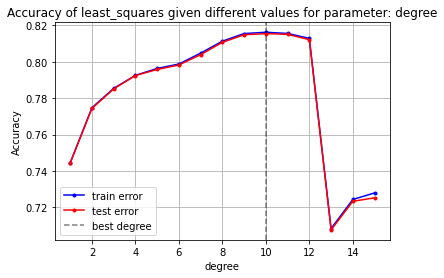

In [28]:
plot_param_vs_err(degrees, accs_tr, accs_te, model, 'Accuracy', save_img = True, img_name = 'least_squares_accuracy')

Plot on MSE gave aberrant values, which illustrates that this loss is not appropriate for categorization, and gets out of hand. We use accuracy for model selection and performance assessment.

Manually choose best parameters

In [29]:
best_degree = 10

Compute performance on k splits with best parameters

In [30]:
model = 'least_squares'
seed = 1
k_fold = 6
k_indices = build_k_indices(y, k_fold, seed)
params = None

accs_te = []
losses_te = []
for k in range(k_fold):
    _, loss_te, _, acc_te = cross_validation(y, tx, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)
    losses_te.append(loss_te)

Starting cross-validation 1/6 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 2/6 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 3/6 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 4/6 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 5/6 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 6/6 for least_squares, extended feature of degree 10 and arguments : None


In [31]:
print('Mean accuracy of best least squares model: ', round(np.mean(accs_te),3))

Mean accuracy of best least squares model:  0.814


Store values for comparison with other models later

In [32]:
np.save('best_models_perf/best_accs_' + model, accs_te)

# Ridge regression

Preprocessing and parameters definition for optimization

In [33]:
y, tx, ids, tX_mean, tX_std = preprocess_data(Y, tX, ids, mean=None, std=None, param={'Build_poly': False})

seed = 1
k_fold = 4 
model = 'ridge_regression'
degrees = np.arange(4,15,1)
lambdas = np.logspace(-6,0,7)

Parameters optimization

In [34]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y, tx, k_fold, model, degrees, lambdas, params = None, seed = seed, feedback = True)

Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 1e-06}
Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 1e-05}
Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 0.0001}
Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 0.001}
Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 0.01}
Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 0.1}
Optimizing degree 4/14, model: ridge_regression, arguments: {'lambda': 1.0}
Optimizing degree 5/14, model: ridge_regression, arguments: {'lambda': 1e-06}
Optimizing degree 5/14, model: ridge_regression, arguments: {'lambda': 1e-05}
Optimizing degree 5/14, model: ridge_regression, arguments: {'lambda': 0.0001}
Optimizing degree 5/14, model: ridge_regression, arguments: {'lambda': 0.001}
Optimizing degree 5/14, model: ridge_regression, arguments: {'lambda': 0.01}
Optimizing degree 5/14, model: ridge_regression, arguments: {'lambda

Here we optimized over 2 parameters, so we use heatmap to visualize best combination

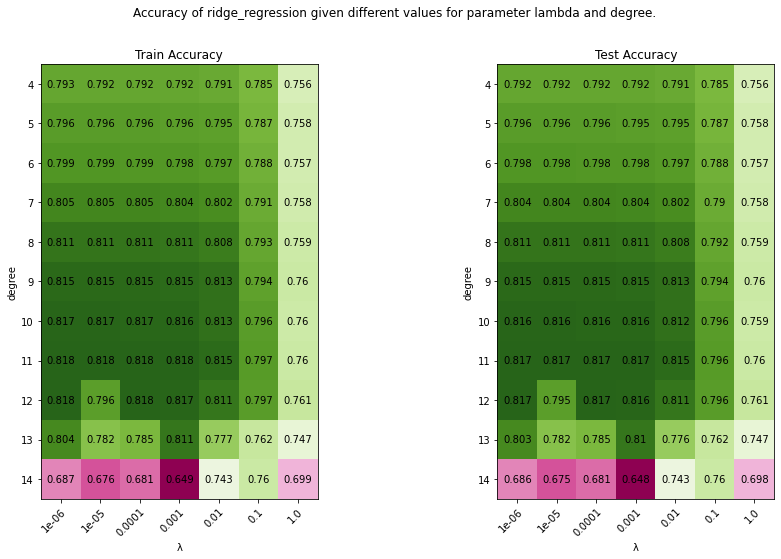

In [35]:
plot_heatmap(accs_tr, accs_te, degrees, lambdas, model, measure_type = 'Accuracy', save_img = True, img_name = 'Heatmap_accuracy_ridge_regression')

Manually choose best parameters

In [36]:
best_lambda = 1e-6
best_degree = 11

Compute performance on k splits with best parameters

In [37]:
model = 'ridge_regression'
seed = 1
k_fold = 6
k_indices = build_k_indices(y, k_fold, seed)
params = {'lambda' : best_lambda}

accs_te = []
losses_te = []
for k in range(k_fold):
    _, loss_te, _, acc_te = cross_validation(y, tx, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)
    losses_te.append(loss_te)

Starting cross-validation 1/6 for ridge_regression, extended feature of degree 11 and arguments : {'lambda': 1e-06}
Starting cross-validation 2/6 for ridge_regression, extended feature of degree 11 and arguments : {'lambda': 1e-06}
Starting cross-validation 3/6 for ridge_regression, extended feature of degree 11 and arguments : {'lambda': 1e-06}
Starting cross-validation 4/6 for ridge_regression, extended feature of degree 11 and arguments : {'lambda': 1e-06}
Starting cross-validation 5/6 for ridge_regression, extended feature of degree 11 and arguments : {'lambda': 1e-06}
Starting cross-validation 6/6 for ridge_regression, extended feature of degree 11 and arguments : {'lambda': 1e-06}


In [38]:
print('Mean accuracy of best ridge regression model: ', round(np.mean(accs_te),3))

Mean accuracy of best ridge regression model:  0.816


Store values for comparison with other models later

In [39]:
np.save('best_models_perf/best_accs_' + model, accs_te)
#np.save('best_models_perf/best_losses_' + model, losses_te)

## Generate predictions and save ouput in csv format for submission:

In [40]:
DATA_TEST_PATH = '../Projet_1_data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
""""""

Ridge trial submission

Model creation and test_data preprocessing

In [41]:
y, tx, ids, tX_mean, tX_std = preprocess_data(Y, tX, ids, mean=None, std=None, param={'Build_poly': True, 'Degree_poly' : 11})
best_lambda = 1e-6
weights, loss = ridge_regression(y, tx, best_lambda)

_, tX_test, ids_test, tX_mean_test, tX_std_test = preprocess_data(_, tX_test, ids_test, mean=None, std=None, param={'Build_poly': True, 'Degree_poly' : 11})

In [ ]:
""""""

In [42]:
OUTPUT_PATH = 'submissions/ridge_1' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)